In [1]:
import pandas as pd

# 데이터 불러오기
df = pd.read_csv("./training_data.csv")

# asset_turnover 컬럼
x = df["asset_turnover"].dropna()

# 평균(μ)와 표준편차(σ)
mu = x.mean()
sigma = x.std(ddof=1)   # sample standard deviation

print("mu :", mu)
print("sigma :", sigma)



mu : 0.07534668083440522
sigma : 0.035673621438357866


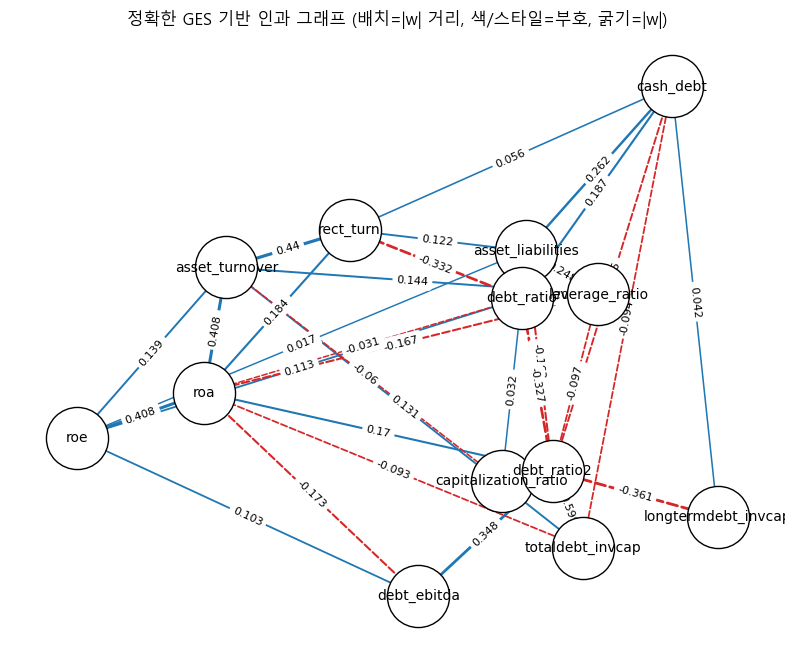

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

# causal-learn: 정확한 GES 구현
from causallearn.search.ScoreBased.GES import ges   # 기본 점수는 BIC
# from causallearn.score.LocalScoreFunction import local_score_BIC

# 한글 폰트/마이너스 설정(선택)
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 0) 데이터 로드 (기존과 동일)
df = pd.read_csv("training_data.csv")
feature_cols = df.drop(columns=["Unnamed: 0", "label"]).columns
X_base = df[feature_cols].copy()
y = df["label"].astype(int)
cols_for_w = list(feature_cols)
cols = cols_for_w  # 시각화 라벨 호환

# 1) 정확한 GES 실행 (기본 BIC 점수 사용)
X_np = X_base.values.astype(float)
Record = ges(X_np)  # 또는 Record = ges(X_np, score_func='local_score_BIC')
Gmat = Record['G'].graph  # orientation 행렬 (numpy.ndarray)
# 문서: G.graph[j,i]=1 & G.graph[i,j]=-1 이면 i -> j (i가 부모, j가 자식)

# 2) 방향성 인접행렬 A (i <- j 형태로 저장하기 위해 A[child, parent]=1)
p = len(cols_for_w)
A = np.zeros((p, p), dtype=float)
for i in range(p):
    for j in range(p):
        if i == j:
            continue
        # i -> j ?
        if (Gmat[j, i] == 1) and (Gmat[i, j] == -1):
            A[j, i] = 1.0  # child=j, parent=i

# 3) 표준화 OLS로 엣지 가중치 행렬 W (i <- j)
Z = StandardScaler().fit_transform(X_np)
W = np.zeros_like(A, dtype=float)
for child in range(p):
    parents = np.where(A[child, :] == 1.0)[0]
    if parents.size == 0:
        continue
    y_child = Z[:, child]
    X_par = Z[:, parents]
    coef, *_ = np.linalg.lstsq(X_par, y_child, rcond=None)  # 절편 없음(표준화)
    W[child, parents] = coef.astype(float)

# ============ 여기부터 시각화 개선(음수 가중치 지원) ============

# 시각화 임계 설정
USE_QUANTILE = False      # 분위수 임계 사용 여부
W_THRESHOLD = 0.01        # 고정 임계(|W|>0.01)
W_ABS_QUANTILE = 0.90     # 상위 10%만 (USE_QUANTILE=True일 때 사용)

TOP_K_EDGES = None        # 상위 |w| 간선만 표시하고 싶으면 정수(예: 100)로 설정

def get_threshold(W, fixed=W_THRESHOLD, use_q=USE_QUANTILE, q=W_ABS_QUANTILE):
    if not use_q:
        return fixed
    aw = np.abs(W).ravel()
    aw = aw[aw > 0]
    return float(np.quantile(aw, q)) if aw.size else fixed

thr = get_threshold(W)

# 4) 임계 적용 + (선택) 상위 K개 필터 → DiGraph 구성
edges_all = []
for i in range(p):
    for j in range(p):
        if i == j:
            continue
        w = float(W[i, j])
        if abs(w) > thr:
            edges_all.append((cols[j], cols[i], w))  # parent -> child, weight=w

# 상위 K개만 표시(선택)
if TOP_K_EDGES is not None and TOP_K_EDGES > 0 and len(edges_all) > TOP_K_EDGES:
    edges_all = sorted(edges_all, key=lambda t: abs(t[2]), reverse=True)[:TOP_K_EDGES]

G = nx.DiGraph()
for u, v, w in edges_all:
    G.add_edge(u, v, weight=round(w, 3))

# ---- 배치: 음수 가중치 문제 해결 (거리=1/(|w|+ε)로 양의 거리 그래프 H 구성)
eps = 1e-6
H = nx.Graph()  # 레이아웃 전용 보조 그래프(무향 + 양의 거리)
for u, v, d in G.edges(data=True):
    w = d.get("weight", 0.0)
    dist = 1.0 / (abs(w) + eps)   # |w| 클수록 더 가까워지도록
    H.add_edge(u, v, weight=dist)

pos = nx.kamada_kawai_layout(H, weight='weight')  # 안정적 배치

# ---- 스타일: 부호/크기 시각화
max_abs = max((abs(d["weight"]) for _, _, d in G.edges(data=True)), default=1.0)
pos_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] >= 0]
neg_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] < 0]
pos_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in pos_edges]
neg_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in neg_edges]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="white", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=10)

# 양수: 파란 실선 / 음수: 빨간 점선
nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color="tab:blue", width=pos_widths, arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color="tab:red",  width=neg_widths, style="dashed", arrows=True)

# 원래 가중치 라벨(부호 유지)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_size=8)
plt.title("정확한 GES 기반 인과 그래프 (배치=|w| 거리, 색/스타일=부호, 굵기=|w|)")
plt.axis("off")
plt.show()


In [3]:
# === Edge 카운트 & 요약 출력 ===
# (임계 thr와 TOP_K_EDGES 적용 이후의 최종 edge 리스트 기준)
num_edges = len(edges_all)
num_pos = sum(1 for _, _, w in edges_all if w >= 0)
num_neg = num_edges - num_pos

# (참고) 임계 적용 전, W에서 0이 아닌 항목 개수(자기자신 제외)
nonzero_before = int(np.count_nonzero(W))  # 대각선은 원래 0
# 방향성 행렬이므로 (i<-j)와 (j<-i)는 별개 edge입니다.

print(f"[EDGE SUMMARY]")
print(f"- threshold(|w|) = {thr:.6f}")
print(f"- TOP_K_EDGES = {TOP_K_EDGES}")
print(f"- Selected edges (after threshold & Top-K): {num_edges} "
      f"(pos: {num_pos}, neg: {num_neg})")
print(f"- Nonzero W entries before threshold: {nonzero_before}")

for (u, v, w) in sorted(edges_all, key=lambda t: abs(t[2]), reverse=True)[:]:
    print(f"  {u} -> {v}: w={w:+.4f}")


[EDGE SUMMARY]
- threshold(|w|) = 0.010000
- TOP_K_EDGES = None
- Selected edges (after threshold & Top-K): 35 (pos: 22, neg: 13)
- Nonzero W entries before threshold: 35
  debt_ratio -> asset_liabilities: w=-1.0511
  capitalization_ratio -> debt_ratio2: w=+0.9820
  leverage_ratio -> debt_ratio: w=+0.7070
  totaldebt_invcap -> debt_ratio2: w=+0.5995
  rect_turn -> asset_turnover: w=+0.4397
  asset_turnover -> roa: w=+0.4085
  roe -> roa: w=+0.4084
  longtermdebt_invcap -> debt_ratio2: w=-0.3610
  debt_ratio2 -> debt_ebitda: w=+0.3483
  rect_turn -> debt_ratio: w=-0.3325
  debt_ratio -> debt_ratio2: w=-0.3270
  asset_liabilities -> cash_debt: w=+0.2618
  leverage_ratio -> asset_liabilities: w=+0.2477
  debt_ratio -> cash_debt: w=+0.1871
  rect_turn -> roa: w=+0.1845
  roa -> debt_ebitda: w=-0.1731
  roa -> debt_ratio2: w=+0.1700
  leverage_ratio -> roa: w=-0.1670
  asset_liabilities -> debt_ratio2: w=-0.1635
  leverage_ratio -> asset_turnover: w=+0.1442
  roe -> asset_turnover: w=+0.139

In [4]:
# === edges_all 전체를 CSV로 저장 ===
edges_all_df = pd.DataFrame(edges_all, columns=["source", "target", "weight"])
edges_all_df.to_csv("./ges_edges_all.csv", index=False, encoding="utf-8-sig")
print("→ 모든 edge를 ges_edges_all.csv 로 저장했습니다.")


→ 모든 edge를 ges_edges_all.csv 로 저장했습니다.


In [5]:
# === asset_turnover으로 들어가는 edge만 추출해서 출력/저장 ===
target_name = "asset_turnover"

if target_name not in cols:
    raise ValueError(f"{target_name} 이(가) cols 목록에 없습니다. cols를 확인하세요.")

# edges_all: (source, target, weight) = (parent, child, w)
edges_to_rect = [(u, v, w) for (u, v, w) in edges_all if v == target_name]

print("\n[asset_turnover으로 들어가는 edge 목록]")
if not edges_to_rect:
    print("asset_turnover으로 향하는 edge가 없습니다.")
else:
    # |w| 기준 내림차순 정렬 후 출력
    for src, dst, w in sorted(edges_to_rect, key=lambda t: abs(t[2]), reverse=True):
        print(f"{src} - {w:+.4f} - {dst}")

    # CSV로도 저장 (원하면 생략 가능)
    edges_to_rect_df = pd.DataFrame(edges_to_rect,
                                    columns=["source", "target", "weight"])
    edges_to_rect_df.to_csv("./ges_edges_to_asset_turnover.csv",
                            index=False, encoding="utf-8-sig")
    print("→ asset_turnover edge만 모은 ges_edges_to_asset_turnover.csv 저장 완료")



[asset_turnover으로 들어가는 edge 목록]
rect_turn - +0.4397 - asset_turnover
leverage_ratio - +0.1442 - asset_turnover
roe - +0.1394 - asset_turnover
totaldebt_invcap - +0.1313 - asset_turnover
capitalization_ratio - -0.0599 - asset_turnover
→ asset_turnover edge만 모은 ges_edges_to_asset_turnover.csv 저장 완료


In [6]:
import pandas as pd
import numpy as np

# -----------------------------
# 0) 데이터 로드
# -----------------------------
df = pd.read_csv("training_data.csv")

rect = df["rect_turn"].astype(float).values
asset = df["asset_turnover"].astype(float).values

# -----------------------------
# 1) Edge weight
# -----------------------------
w = 0.4397   # rect_turn - +0.4397 - asset_turnover

# -----------------------------
# 2) epsilon 계산
#    rect_turn = w * asset_turnover + ε
# -----------------------------
epsilon = rect - w * asset

mu_eps = epsilon.mean()
sigma_eps = epsilon.std(ddof=1)

# -----------------------------
# 3) 전체식 분포 계산
#    w * asset_turnover + ε  의 분포 = rect_turn 분포여야 함
# -----------------------------
reconstructed = w * asset + epsilon

mu_recon = reconstructed.mean()
sigma_recon = reconstructed.std(ddof=1)

# -----------------------------
# 4) 결과를 "수식 형태"로 출력
# -----------------------------
print("=== OLS 모델 ===")
print(f"rect_turn = {w:.4f} * asset_turnover + ε\n")

print("=== ε 분포 ===")
print(f"ε = rect_turn - {w:.4f} * asset_turnover")
print(f"ε ~ N( μ = {mu_eps:.6f}, σ = {sigma_eps:.6f} )\n")

print("=== (0.4397 * asset_turnover + ε) 분포 ===")
print(f"{w:.4f} * asset_turnover + ε")
print(f"~ N( μ = {mu_recon:.6f}, σ = {sigma_recon:.6f} )\n")

# 필요하면 epsilon 값 자체도 출력
print("=== epsilon 값 일부 ===")
print(epsilon[:20])  # 앞 20개만 예시 출력


=== OLS 모델 ===
rect_turn = 0.4397 * asset_turnover + ε

=== ε 분포 ===
ε = rect_turn - 0.4397 * asset_turnover
ε ~ N( μ = -0.024451, σ = 0.023916 )

=== (0.4397 * asset_turnover + ε) 분포 ===
0.4397 * asset_turnover + ε
~ N( μ = 0.008678, σ = 0.026191 )

=== epsilon 값 일부 ===
[-0.02694746 -0.02842482 -0.02881883 -0.03347607 -0.03613876 -0.04274816
 -0.04495726 -0.03971265 -0.04223828 -0.0403775  -0.03670164 -0.03319464
 -0.03450314 -0.03525936 -0.03716583 -0.03322973 -0.03148152 -0.03007434
 -0.0355799  -0.03705726]


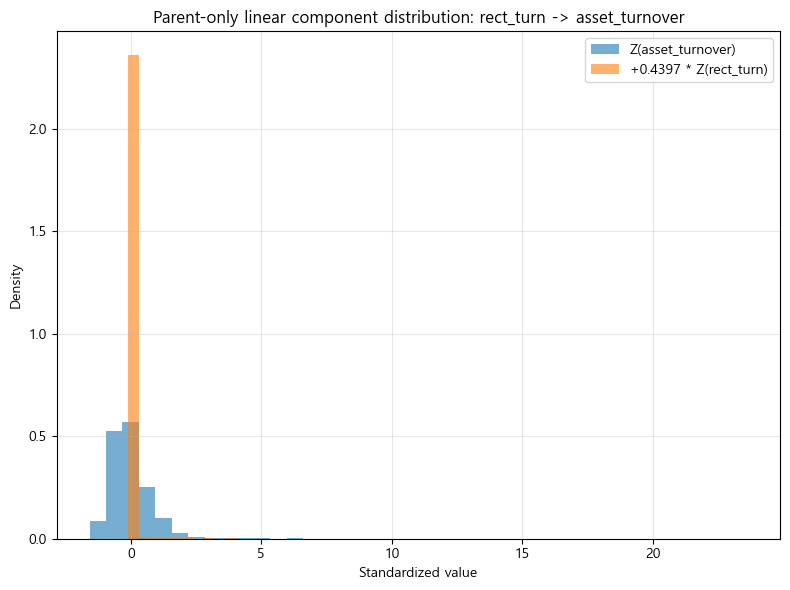

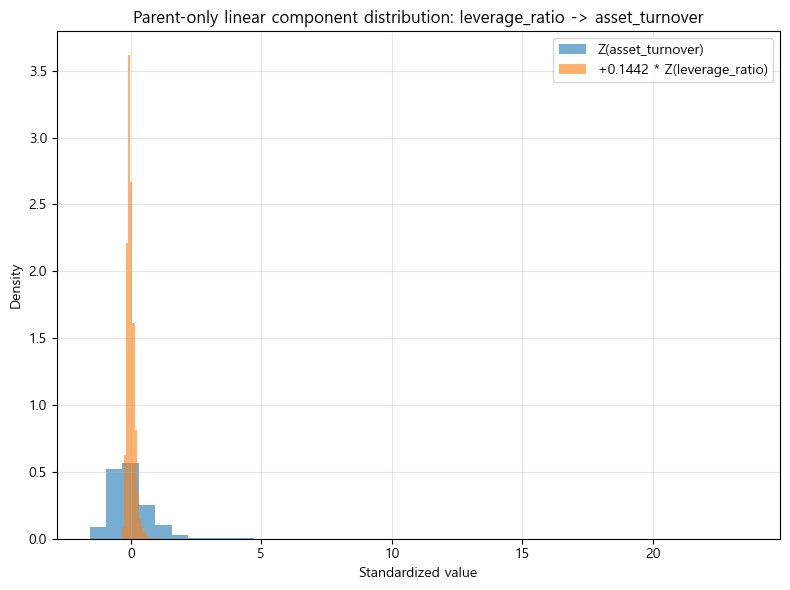

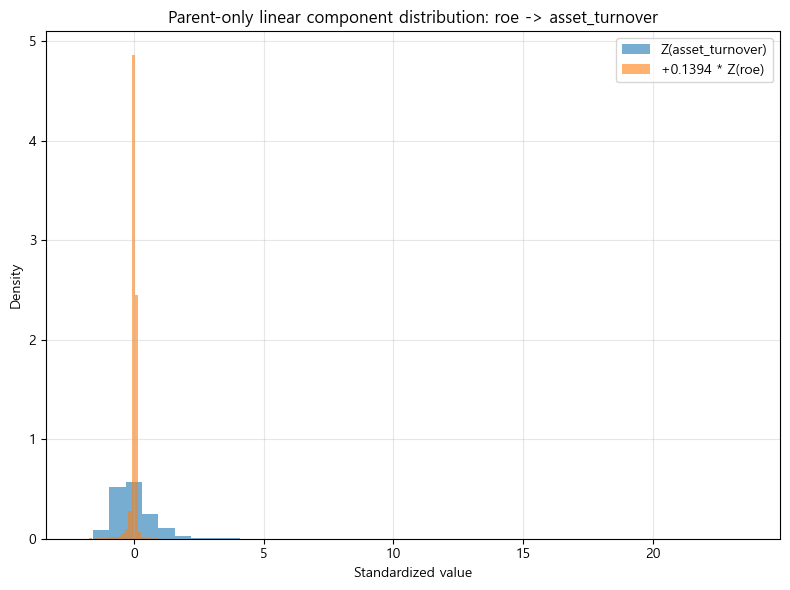

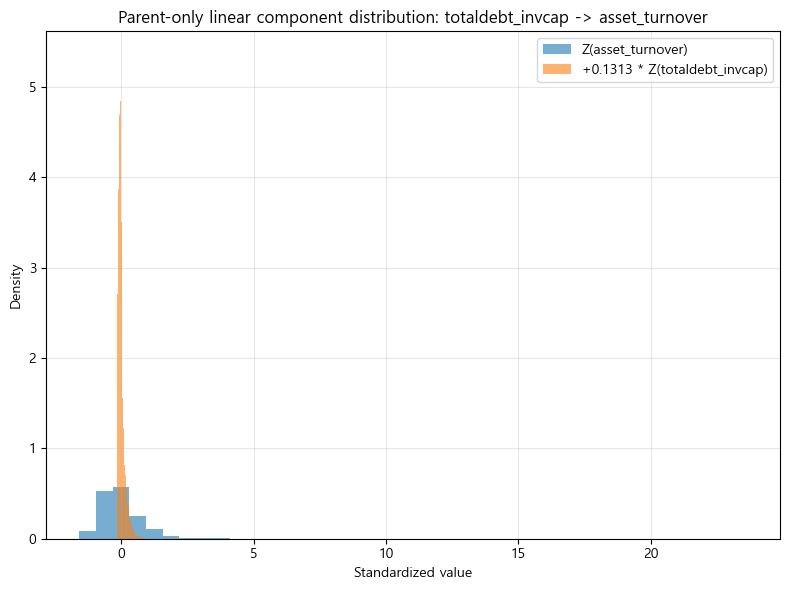

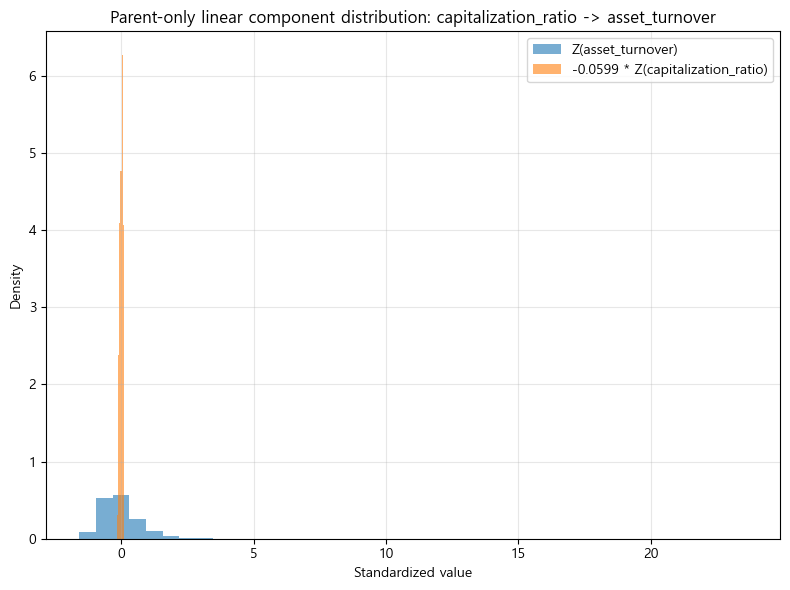

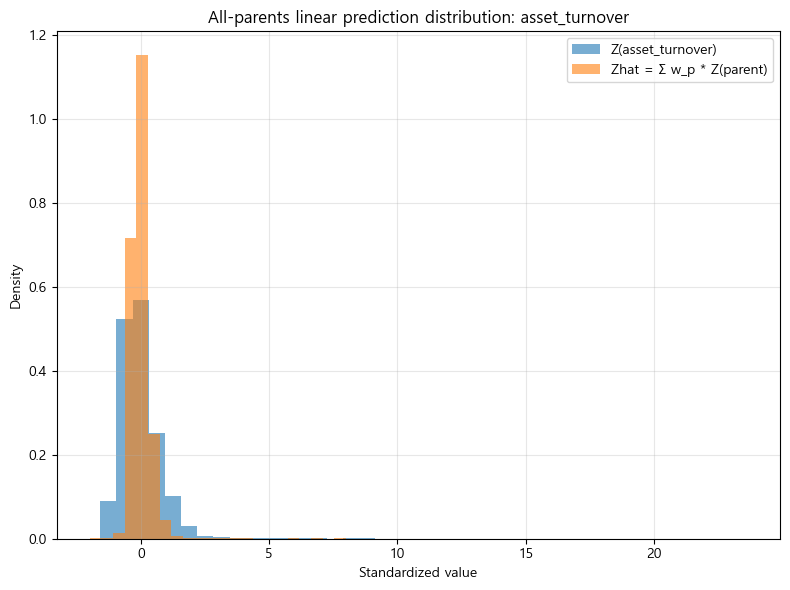

[All-parents summary]
- num_parents = 5
- corr(Z_target, Zhat_all) = 0.5151
- R^2 (in-sample, standardized) = 0.2653

[Per-parent component correlation with target (not R^2, just association)]
-            rect_turn  w=+0.4397  corr(Z_target, w*Z_p)=0.4382
-       leverage_ratio  w=+0.1442  corr(Z_target, w*Z_p)=0.1583
-                  roe  w=+0.1394  corr(Z_target, w*Z_p)=0.1443
-     totaldebt_invcap  w=+0.1313  corr(Z_target, w*Z_p)=0.2237
- capitalization_ratio  w=-0.0599  corr(Z_target, w*Z_p)=0.0057


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ---------------------------------
# 0) 설정
# ---------------------------------
DATA_PATH  = "training_data.csv"
EDGES_PATH = "ges_edges_all.csv"
TARGET = "asset_turnover"

# 시각화 옵션
BINS = 40
SHOW_TARGET_DIST = True   # 실제 Z(asset_turnover) 분포도 같이 보여줄지

# ---------------------------------
# 1) 데이터 로드
# ---------------------------------
df = pd.read_csv(DATA_PATH)
edges = pd.read_csv(EDGES_PATH)

if not {"source", "target", "weight"}.issubset(edges.columns):
    raise ValueError("ges_edges_all.csv는 source, target, weight 컬럼이 필요합니다.")

# asset_turnover로 들어오는 부모들(직접 parent) 추출
parents_df = edges.loc[edges["target"] == TARGET, ["source", "weight"]].copy()
parents_df = parents_df.sort_values(by="weight", key=lambda s: s.abs(), ascending=False)

parent_cols = parents_df["source"].tolist()
if len(parent_cols) == 0:
    raise ValueError("asset_turnover의 부모가 없습니다. threshold 설정 또는 edges 파일을 확인하세요.")

# 필요한 컬럼만 뽑아서 수치형 변환 후 결측 제거
use_cols = [TARGET] + parent_cols
X = df[use_cols].apply(pd.to_numeric, errors="coerce").dropna()

# ---------------------------------
# 2) 표준화 (Z-score)
# ---------------------------------
scaler = StandardScaler()
Z = scaler.fit_transform(X.values)

col_to_idx = {c: i for i, c in enumerate(use_cols)}
z_target = Z[:, col_to_idx[TARGET]]

# ---------------------------------
# 3) 부모별 "선형 성분"과 전체 결합 예측값 생성
#    - 부모별 성분: comp_p = w_p * Z_p
#    - 전체 결합: zhat = Σ w_p * Z_p
# ---------------------------------
zhat_all = np.zeros_like(z_target)

components = []  # (parent, weight, comp_array)
for _, row in parents_df.iterrows():
    p = row["source"]
    w = float(row["weight"])
    z_p = Z[:, col_to_idx[p]]

    comp = w * z_p
    components.append((p, w, comp))
    zhat_all += comp

# ---------------------------------
# 4) (A) 부모별 분포: 부모 하나씩의 선형 성분(comp) vs 실제 target 분포
# ---------------------------------
for p, w, comp in components:
    plt.figure(figsize=(8, 6))

    if SHOW_TARGET_DIST:
        plt.hist(z_target, bins=BINS, density=True, alpha=0.6, label="Z(asset_turnover)")

    plt.hist(comp, bins=BINS, density=True, alpha=0.6, label=f"{w:+.4f} * Z({p})")

    plt.xlabel("Standardized value")
    plt.ylabel("Density")
    plt.title(f"Parent-only linear component distribution: {p} -> {TARGET}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ---------------------------------
# 5) (B) 모든 부모 결합 분포: zhat_all vs 실제 target 분포
# ---------------------------------
plt.figure(figsize=(8, 6))

if SHOW_TARGET_DIST:
    plt.hist(z_target, bins=BINS, density=True, alpha=0.6, label="Z(asset_turnover)")

plt.hist(zhat_all, bins=BINS, density=True, alpha=0.6, label="Zhat = Σ w_p * Z(parent)")

plt.xlabel("Standardized value")
plt.ylabel("Density")
plt.title("All-parents linear prediction distribution: asset_turnover")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------
# 6) 참고 지표 출력 (분포 유사성 느낌 확인용)
# ---------------------------------
corr_all = np.corrcoef(z_target, zhat_all)[0, 1]
r2_all = 1.0 - np.sum((z_target - zhat_all) ** 2) / np.sum((z_target - np.mean(z_target)) ** 2)

print("[All-parents summary]")
print(f"- num_parents = {len(parent_cols)}")
print(f"- corr(Z_target, Zhat_all) = {corr_all:.4f}")
print(f"- R^2 (in-sample, standardized) = {r2_all:.4f}")

print("\n[Per-parent component correlation with target (not R^2, just association)]")
for p, w, comp in components:
    corr_p = np.corrcoef(z_target, comp)[0, 1]
    print(f"- {p:>20s}  w={w:+.4f}  corr(Z_target, w*Z_p)={corr_p:.4f}")


[All-parents OLS]
- num_parents = 5
- test R^2    = 0.2247
- corr(y, yhat)= 0.5149


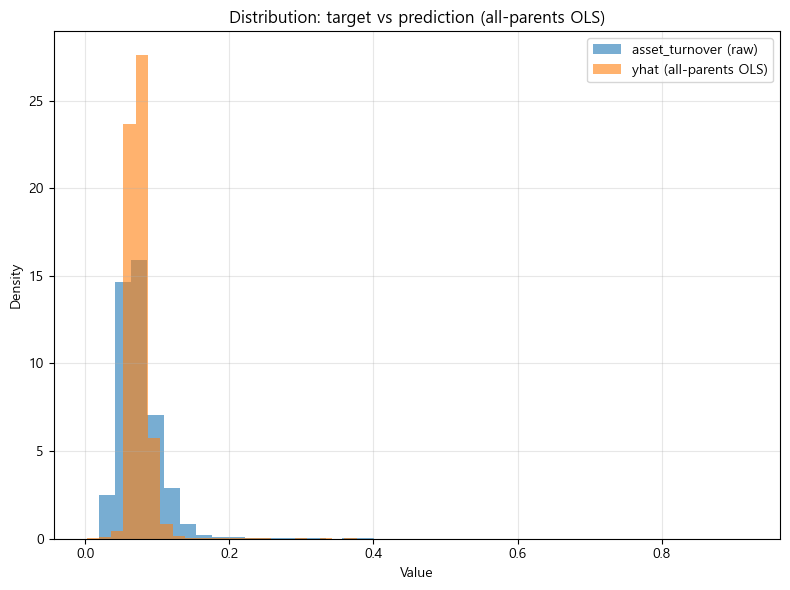

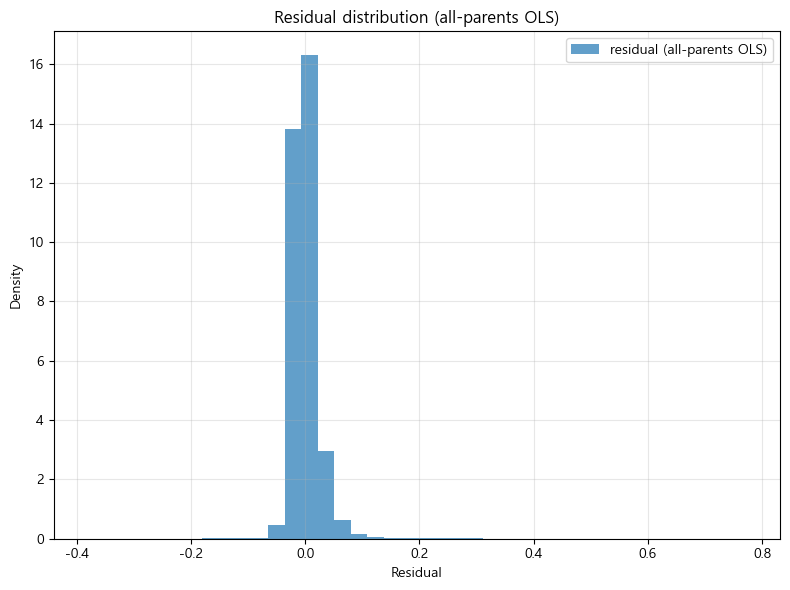

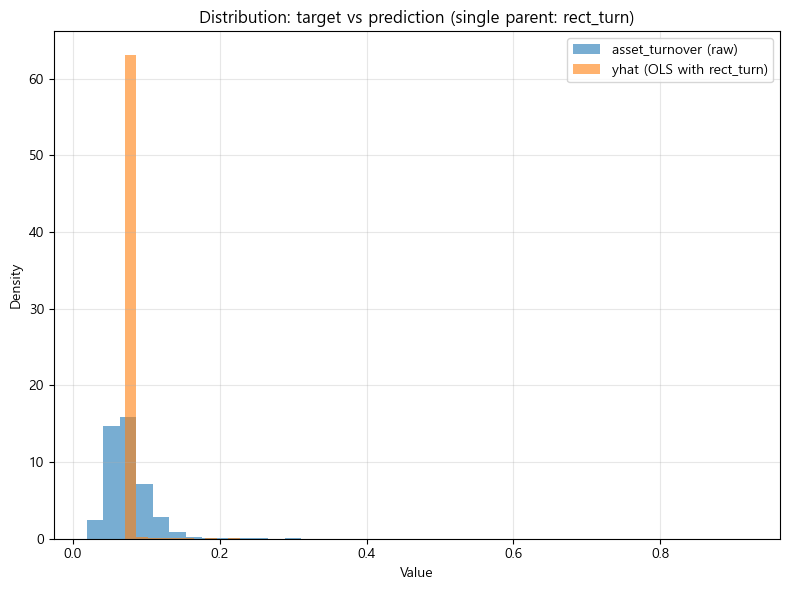

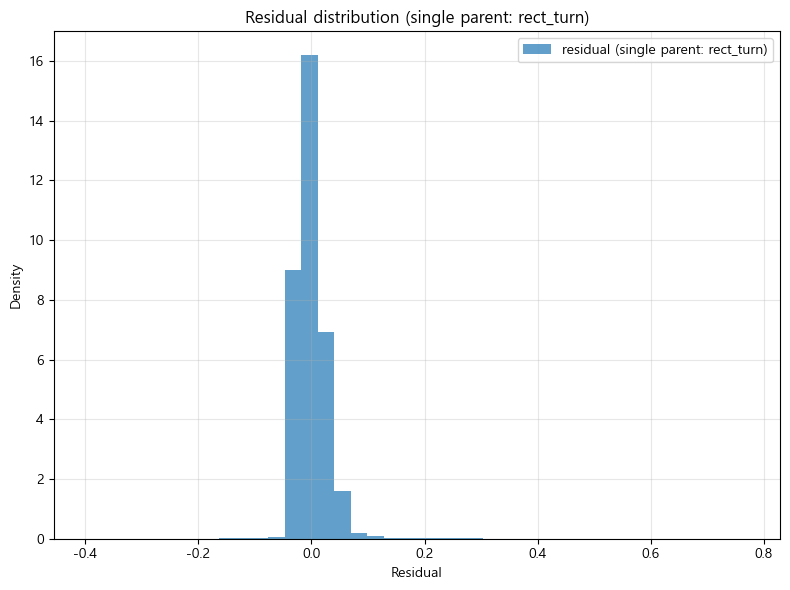

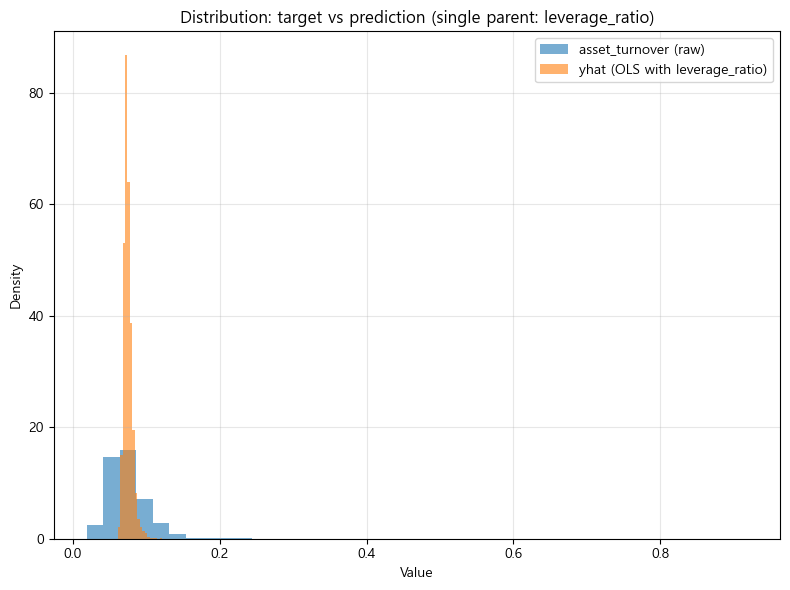

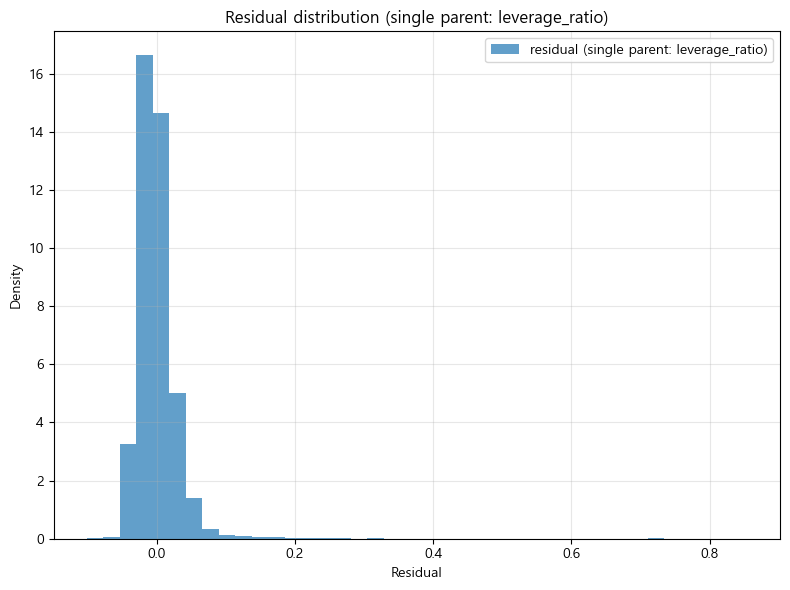

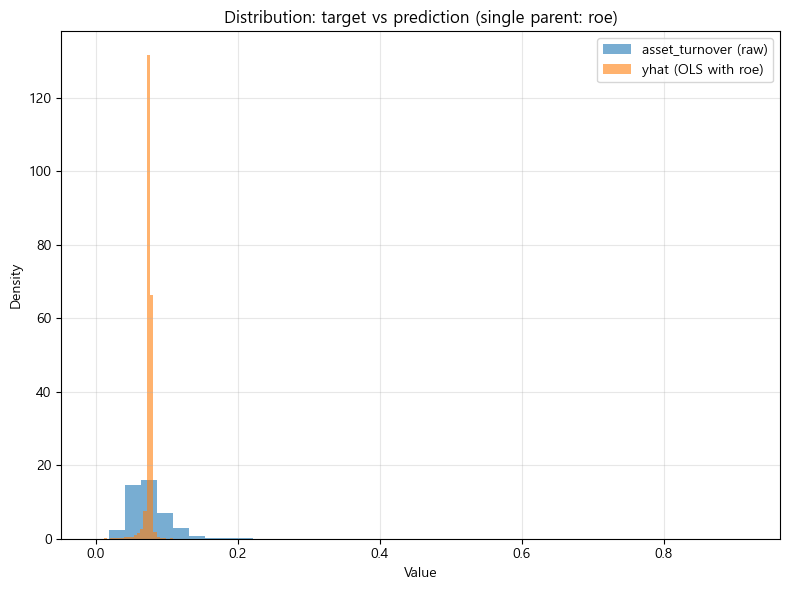

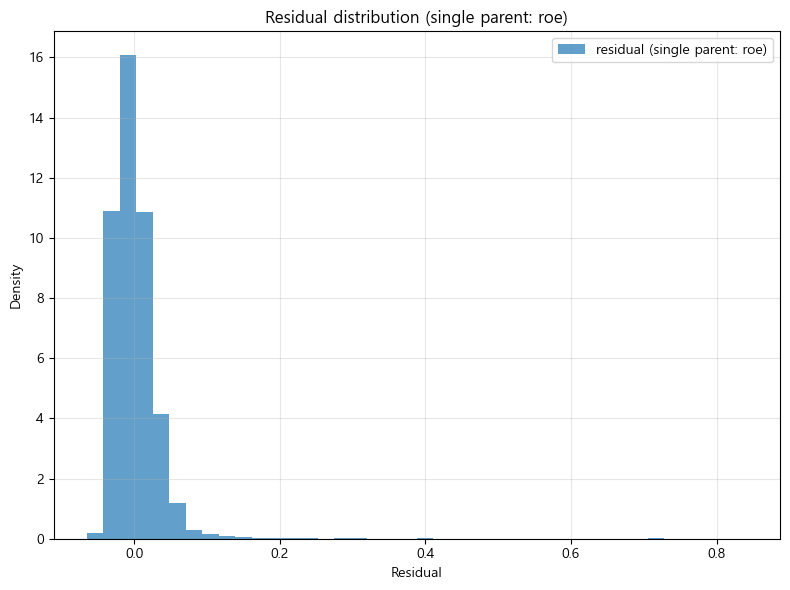

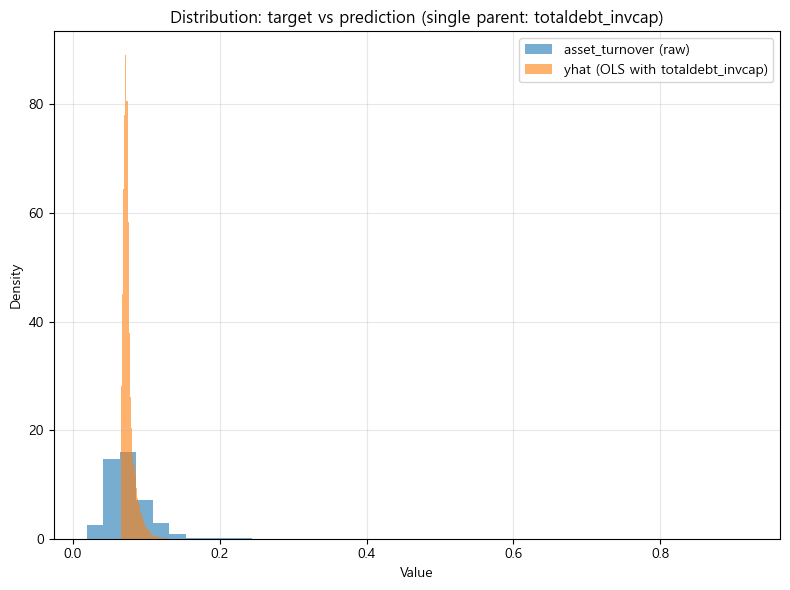

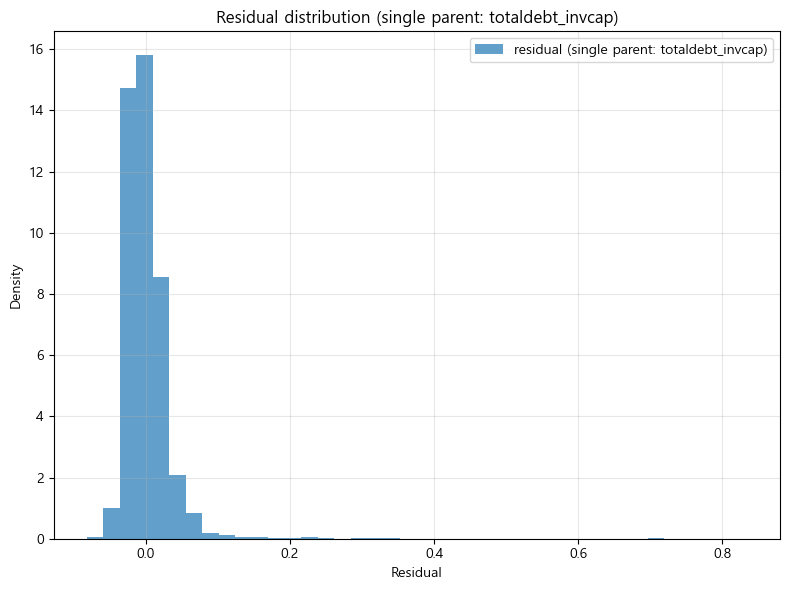

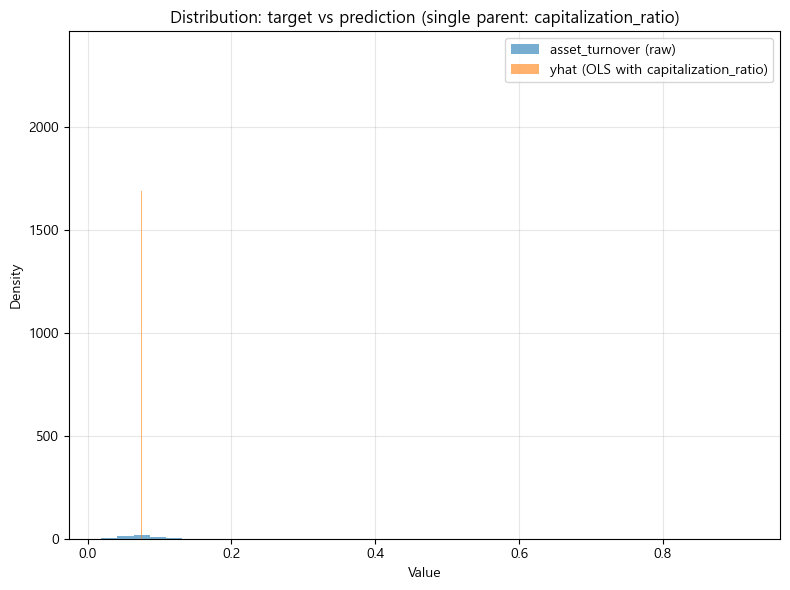

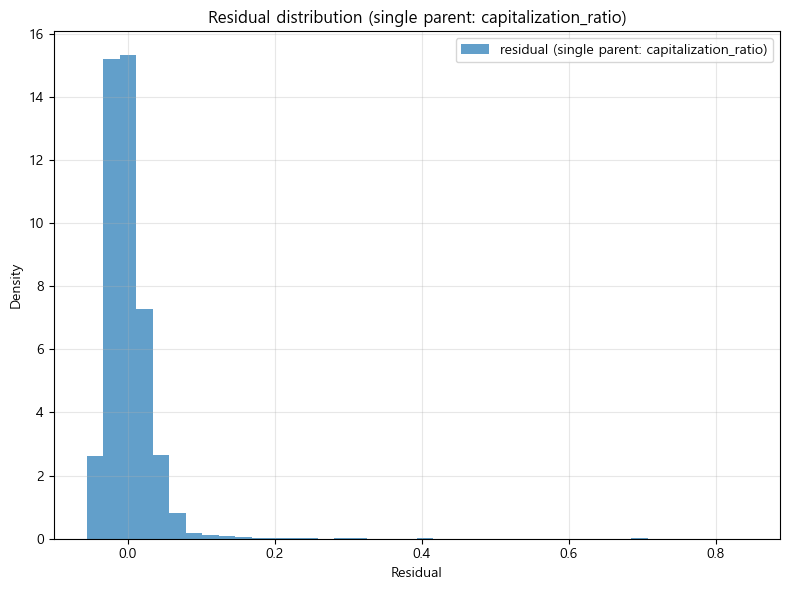


[Single-parent OLS summary (sorted by test R^2)]
              parent   test_R2  corr(y,yhat)  coef_std  intercept
           rect_turn  0.172097      0.438207  0.015210   0.075142
    totaldebt_invcap  0.041999      0.223680  0.007843   0.075142
                 roe  0.017392      0.144309  0.005048   0.075142
      leverage_ratio  0.006804      0.158321  0.006047   0.075142
capitalization_ratio -0.000563      0.005698 -0.000160   0.075142


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# -----------------------------
# 0) 설정
# -----------------------------
DATA_PATH  = "training_data.csv"
EDGES_PATH = "ges_edges_all.csv"
TARGET = "asset_turnover"

BINS = 40
TEST_SIZE = 0.2
RANDOM_STATE = 42

# -----------------------------
# 1) 로드 + 부모 추출
# -----------------------------
df = pd.read_csv(DATA_PATH)
edges = pd.read_csv(EDGES_PATH)

parents_df = edges.loc[edges["target"] == TARGET, ["source", "weight"]].copy()
parents_df["absw"] = parents_df["weight"].abs()
parents_df = parents_df.sort_values("absw", ascending=False)

parents = parents_df["source"].tolist()
if len(parents) == 0:
    raise ValueError("부모가 없습니다. threshold / edges 파일 확인 필요")

# 수치형 변환 + 결측 제거
use_cols = [TARGET] + parents
data = df[use_cols].apply(pd.to_numeric, errors="coerce").dropna()

y = data[TARGET].values
X_all = data[parents].values

# train/test 분할 (분포 그림은 전체로, 성능은 test로도 보고 싶으면 아래 사용)
Xtr, Xte, ytr, yte = train_test_split(X_all, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# -----------------------------
# 2) (B) 부모 전체 다변량 OLS
# -----------------------------
sc_all = StandardScaler().fit(Xtr)
lr_all = LinearRegression().fit(sc_all.transform(Xtr), ytr)

yhat_all = lr_all.predict(sc_all.transform(X_all))      # 전체 데이터에 대한 예측
res_all  = y - yhat_all                                 # 잔차

# test 성능
yhat_te_all = lr_all.predict(sc_all.transform(Xte))
r2_te_all = r2_score(yte, yhat_te_all)
corr_all = np.corrcoef(y, yhat_all)[0, 1]

print("[All-parents OLS]")
print(f"- num_parents = {len(parents)}")
print(f"- test R^2    = {r2_te_all:.4f}")
print(f"- corr(y, yhat)= {corr_all:.4f}")

# 분포 그림: 실제 y vs 예측 yhat_all
plt.figure(figsize=(8,6))
plt.hist(y, bins=BINS, density=True, alpha=0.6, label=f"{TARGET} (raw)")
plt.hist(yhat_all, bins=BINS, density=True, alpha=0.6, label="yhat (all-parents OLS)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Distribution: target vs prediction (all-parents OLS)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 잔차 분포
plt.figure(figsize=(8,6))
plt.hist(res_all, bins=BINS, density=True, alpha=0.7, label="residual (all-parents OLS)")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.title("Residual distribution (all-parents OLS)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 3) (A) 부모 1개씩 단변량 OLS
# -----------------------------
uni_results = []
for j, p in enumerate(parents):
    Xp = data[[p]].values
    Xp_tr, Xp_te, ytr_u, yte_u = train_test_split(Xp, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    sc = StandardScaler().fit(Xp_tr)
    lr = LinearRegression().fit(sc.transform(Xp_tr), ytr_u)

    yhat = lr.predict(sc.transform(Xp))   # 전체 예측
    res  = y - yhat

    yhat_te = lr.predict(sc.transform(Xp_te))
    r2_te = r2_score(yte_u, yhat_te)
    corr = np.corrcoef(y, yhat)[0, 1]

    uni_results.append({
        "parent": p,
        "test_R2": r2_te,
        "corr(y,yhat)": corr,
        "coef_std": float(lr.coef_[0]),   # 표준화된 X에서의 계수 (y는 raw)
        "intercept": float(lr.intercept_)
    })

    # 분포 그림(단변량): 실제 y vs 예측
    plt.figure(figsize=(8,6))
    plt.hist(y, bins=BINS, density=True, alpha=0.6, label=f"{TARGET} (raw)")
    plt.hist(yhat, bins=BINS, density=True, alpha=0.6, label=f"yhat (OLS with {p})")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title(f"Distribution: target vs prediction (single parent: {p})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 잔차 분포
    plt.figure(figsize=(8,6))
    plt.hist(res, bins=BINS, density=True, alpha=0.7, label=f"residual (single parent: {p})")
    plt.xlabel("Residual")
    plt.ylabel("Density")
    plt.title(f"Residual distribution (single parent: {p})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

uni_df = pd.DataFrame(uni_results).sort_values("test_R2", ascending=False)
print("\n[Single-parent OLS summary (sorted by test R^2)]")
print(uni_df.to_string(index=False))

# -----------------------------
# 4) 결과 저장(원하면)
# -----------------------------
uni_df.to_csv("single_parent_ols_summary.csv", index=False, encoding="utf-8-sig")

# all-parents 예측/잔차도 저장
pd.DataFrame({
    "y": y,
    "yhat_all": yhat_all,
    "res_all": res_all
}).to_csv("all_parents_ols_pred_resid.csv", index=False, encoding="utf-8-sig")


[INFO] Number of numeric variables: 14


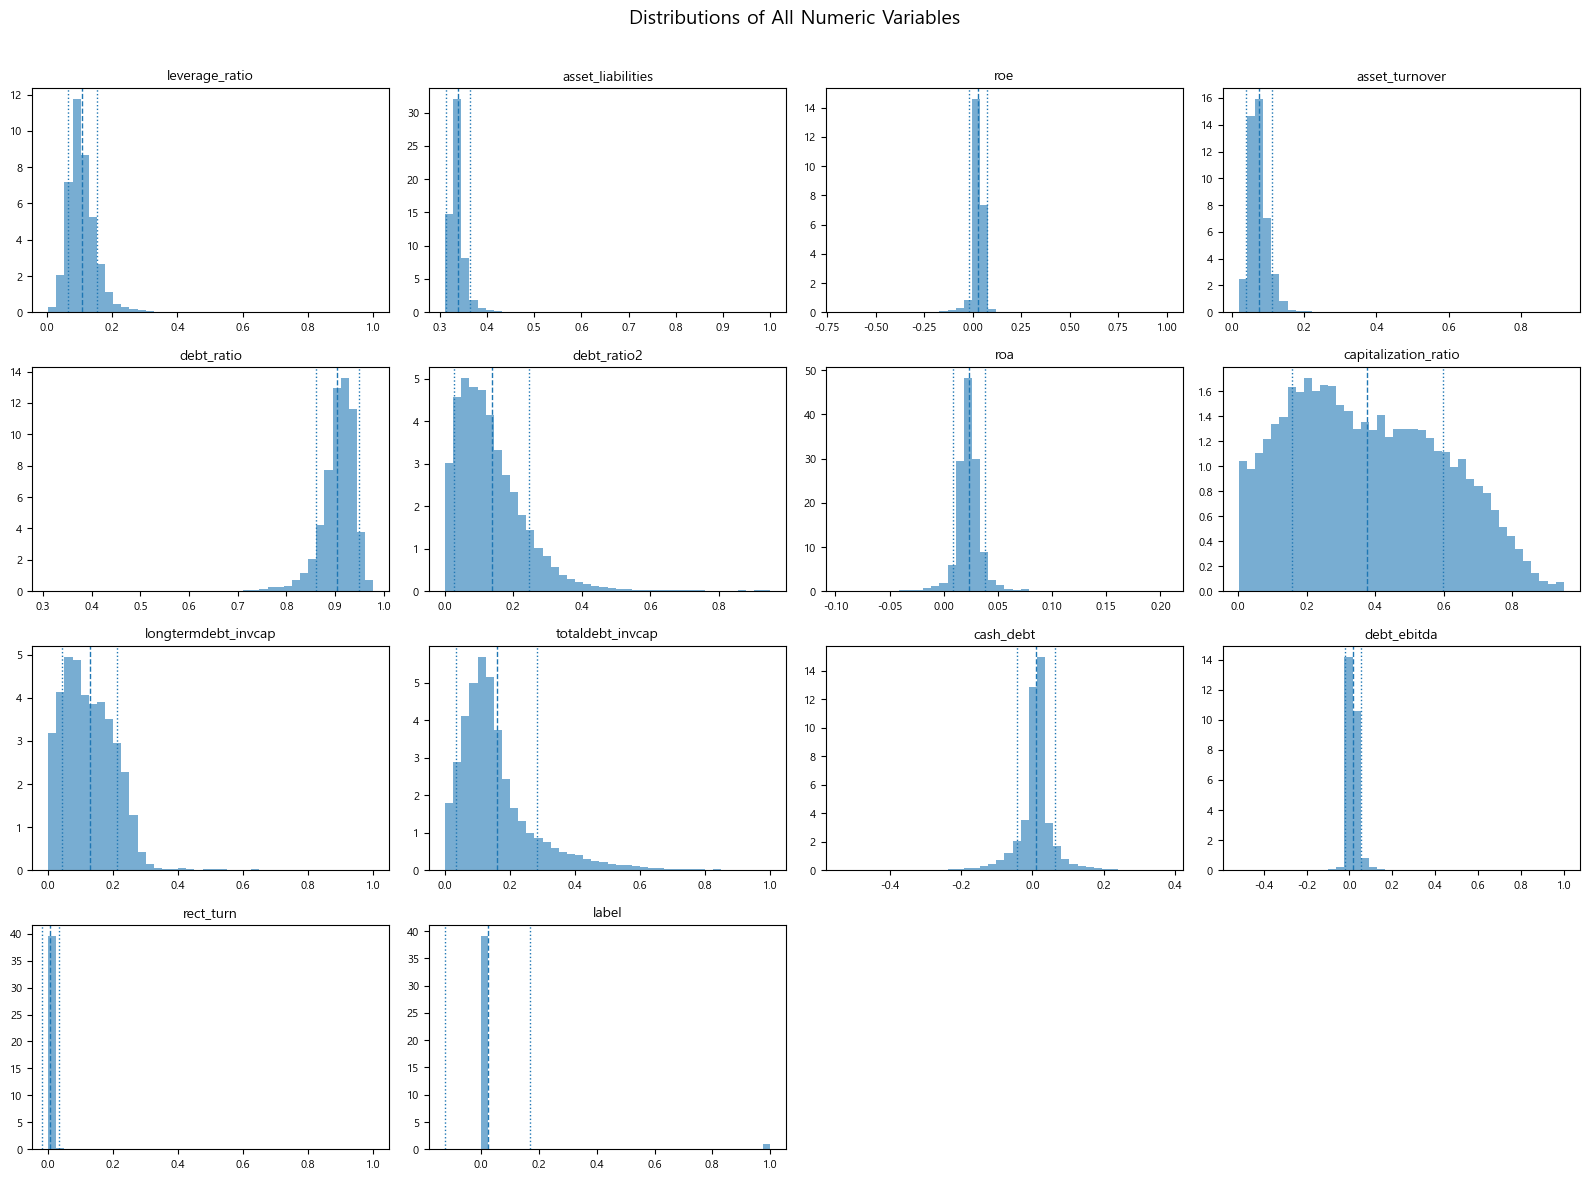

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# ---------------------------------
# 0) 데이터 로드
# ---------------------------------
df = pd.read_csv("training_data.csv")

# ---------------------------------
# 1) 수치형 컬럼만 선택
# ---------------------------------
num_df = df.select_dtypes(include=[np.number]).copy()

# 불필요한 인덱스 컬럼 제거 (있을 경우)
for col in ["Unnamed: 0", "index", "id"]:
    if col in num_df.columns:
        num_df = num_df.drop(columns=[col])

cols = num_df.columns.tolist()
n = len(cols)

print(f"[INFO] Number of numeric variables: {n}")

# ---------------------------------
# 2) subplot grid 크기 계산
# ---------------------------------
n_cols = 4                          # 한 줄에 4개 (조절 가능)
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 3 * n_rows),
    squeeze=False
)

# ---------------------------------
# 3) 각 변수 분포 그리기
# ---------------------------------
for idx, col in enumerate(cols):
    r = idx // n_cols
    c = idx % n_cols
    ax = axes[r, c]

    x = num_df[col].dropna().values
    if len(x) == 0:
        ax.set_visible(False)
        continue

    mu = np.mean(x)
    sigma = np.std(x, ddof=1)

    ax.hist(x, bins=40, density=True, alpha=0.6)
    
    # 평균 / ±1σ 표시
    ax.axvline(mu, linestyle="--", linewidth=1)
    ax.axvline(mu + sigma, linestyle=":", linewidth=1)
    ax.axvline(mu - sigma, linestyle=":", linewidth=1)

    ax.set_title(col, fontsize=10)
    ax.tick_params(axis='both', labelsize=8)

# 남는 subplot 숨김
for j in range(n, n_rows * n_cols):
    r = j // n_cols
    c = j % n_cols
    axes[r, c].set_visible(False)

plt.suptitle("Distributions of All Numeric Variables", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
